# Bennets Hipathia Script

## 1. Instalation & Setup

In [1]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}
# --- Install pheatmap if missing ---
if (!requireNamespace("pheatmap", quietly = TRUE)) {
    install.packages("pheatmap")
}
# Install BiocManager only if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

## Set Bioconductor version COMPATIBLE with R 4.3.x
BiocManager::install(version = "3.18")

## Install edgeR from Bioconductor 3.18
BiocManager::install("edgeR")

# --- Load core libraries ---
library(dplyr)
library(pheatmap)
library(hipathia)
library(data.table)
library(matrixStats)
# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")

## ==========================
## Pakete
## ==========================
library(data.table)    # schnelles IO + Aggregation
library(matrixStats)   # schnelle rowVars / rowSds
# Optional, aber stark empfohlen für große PCA:
use_irlba <- TRUE
if (use_irlba) {
  if (!requireNamespace("irlba", quietly = TRUE)) {
    install.packages("irlba")
  }
  library(irlba)
}



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Old packages: 'data.table', 'igraph'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'data.table', 'igraph'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 

[1] ‘3.2.0’

[1] ‘1.2.0’

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




## 2. Parameters

### 2.1 Set Paramter 

In [2]:
# ---- Input files ----
rna_path  <- "RNA_filtered_by_patient7,13,786.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "normal"        # name in output (left in Hipathia)
group2_name  <- "tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")Mesothelium
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways

eps_neutral <- 0.1



## 3. Patient Filter &Metadata Processing

### 3.1 Load metadata & basic preprocessing


In [3]:
meta <- fread(meta_path, data.table = FALSE)

# Check auf notwendige Spalten
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Patient-ID: pXXXpos / pXXXneg -> pXXX
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Nur relevante Celltypes behalten
meta_filt <- meta[meta[[group_column]] %in% allowed_groups, , drop = FALSE]

### 3.2 Patient filtering based on cell-type abundance


In [4]:
# Zellzahlen pro Patient × Celltype
cell_counts <- with(
  meta_filt,
  table(patient_id, .subset2(meta_filt, group_column))
)

# Summen für group1 / group2
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Patienten, die genug Zellen von BEIDEN Gruppen haben
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))
if (length(valid_patients) == 0) {
  stop("Kein Patient erfüllt min_cells-Kriterium für beide Gruppen.")
}

## Diagnose-Tabelle (falls du sie brauchst)
patients <- rownames(cell_counts)
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

### 3.3 Diagnostic table & final metadata assembly


In [5]:

# Summen für group1 / group2
diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), ] <- as.numeric(group1_counts[patients])
diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), ] <- as.numeric(group2_counts[patients])

# Einzelne Celltypes
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}

diagnosis_matrix["keep", ] <- ifelse(
  group1_counts[patients] >= min_cells & group2_counts[patients] >= min_cells,
  "TRUE", "FALSE"
)

diagnosis_table <- as.data.frame(diagnosis_matrix, stringsAsFactors = FALSE)
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Finales Metadata nur mit validen Patienten
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, , drop = FALSE]

# Normal/Tumor Label
meta_final$group <- ifelse(
  meta_final[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Barcodes, die nach Filter übrig sind
filtered_barcodes <- unique(meta_final$cell_id)
if (length(filtered_barcodes) == 0) {
  stop("Patient filter produced zero remaining cell barcodes.")
}
message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))


                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "normal"     0     0
Mesothelium                0     0
group2_name = "tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: normal vs tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [6]:
# kleines Trim-Utility
trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]])) {
      df[[i]] <- trimws(df[[i]])
    }
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]
  if (length(non_na) == 0) return(FALSE)

  mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
}



### 4.2. Read RNA File

In [7]:
rna_raw <- fread(rna_path, data.table = FALSE)
rna_raw <- trim_all(rna_raw)

# Gene-Spalte finden
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
  gene_col <- gene_name_hits
} else {
  first_col <- rna_raw[[1]]
  if (looks_gene_symbol(head(first_col, 200))) {
    gene_col <- 1
  } else {
    cand <- which(sapply(rna_raw, function(col) looks_gene_symbol(head(col, 200))))
    gene_col <- cand[1]
  }
}

if (is.na(gene_col) || length(gene_col) == 0) {
  stop("Could not detect gene column.")
}

colnames(rna_raw)[gene_col] <- "Gene"

### 4.4. Standardization RNA Matrix

In [8]:
rna_barcodes   <- setdiff(colnames(rna_raw), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

if (length(keep_barcodes) == 0) {
  stop("No overlapping barcodes between RNA and filtered metadata.")
}

# Nur Gene + benötigte Barcodes
rna <- rna_raw[, c("Gene", keep_barcodes), drop = FALSE]

# Numeric-Konvertierung vektorisiert
rna[, keep_barcodes] <- lapply(rna[, keep_barcodes, drop = FALSE], function(x) {
  x <- trimws(as.character(x))
  x[x == ""] <- NA
  suppressWarnings(as.numeric(x))
})

# Leere Gene droppen
rna$Gene <- trimws(as.character(rna$Gene))
rna <- rna[rna$Gene != "" & !is.na(rna$Gene), , drop = FALSE]

# Duplikate effizient mit data.table collapsen
if (anyDuplicated(rna$Gene)) {
  message("Duplicate genes detected → collapsing by sum (data.table).")
  dt <- as.data.table(rna)
  rna_dt <- dt[, lapply(.SD, sum, na.rm = TRUE), by = Gene]
  setcolorder(rna_dt, c("Gene", keep_barcodes))
  rna <- as.data.frame(rna_dt)
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

Wrote standardized RNA: 996 barcodes kept.



## 5. PCA befor and after Patient filter

### 5.1. PCA utility function (variance filtering)

In [9]:
run_pca <- function(mat, n_pc = 20) {
  # Gene mit Varianz > 0
  vars <- rowVars(mat, useNames = FALSE, na.rm = TRUE)
  mat2 <- mat[vars > 0, , drop = FALSE]

  if (use_irlba) {
    irlba::prcomp_irlba(t(mat2), n = n_pc, center = TRUE, scale. = TRUE)
  } else {
    prcomp(t(mat2), scale. = TRUE)
  }
}


### 5.2. PCA before Patient Filter

### 5.3. PCA after Patient Filter

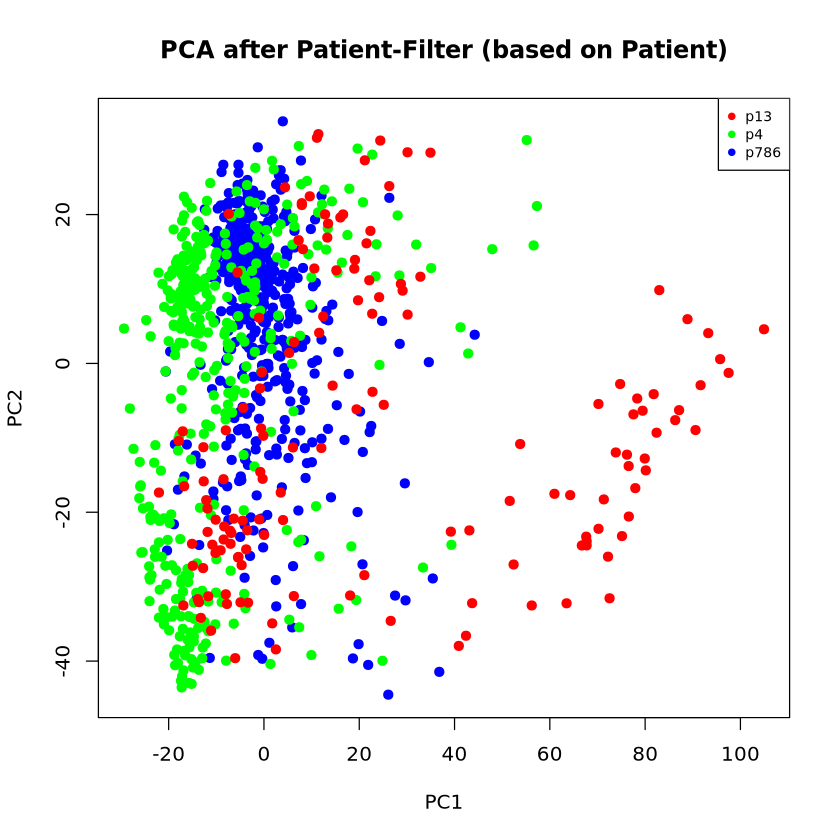

In [10]:

filt_barcodes <- keep_barcodes
pca_filt_mat <- as.matrix(rna[, filt_barcodes, drop = FALSE])
pca_filt <- run_pca(pca_filt_mat, n_pc = 10)

filt_meta <- meta_final[match(filt_barcodes, meta_final$cell_id), ]
patient_filt <- factor(filt_meta$patient_id)
pal_filt <- rainbow(length(levels(patient_filt)))
cols_filt <- pal_filt[patient_filt]

plot(
  pca_filt$x[, 1], pca_filt$x[, 2],
  xlab = "PC1", ylab = "PC2",
  main = "PCA after Patient-Filter (based on Patient)",
  pch = 19, col = cols_filt
)
legend("topright", legend = levels(patient_filt), col = pal_filt, pch = 19, cex = 0.7)


## Check

### 5.1. Check: cells per patient X


In [11]:
## ==========================
## Inspect patient cell composition
## ==========================

cat("\n===== Inspecting patient:", inspect_sample, "=====\n")

# Direkter Filter
meta_inspect <- meta[meta$orig.ident == inspect_sample, , drop = FALSE]

if (nrow(meta_inspect) == 0) {
  stop("No cells found for patient: ", inspect_sample)
}

# Liste der einzigartigen Zelltypen
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])
cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Counts pro Celltype
celltype_counts <- table(meta_inspect[[group_column]])
cat("\nCell counts for patient", inspect_sample, ":\n")
print(celltype_counts)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting patient: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
  

### 5.2. Check: Barcode Overlap AFTER standardization

In [12]:
meta_ids <- unique(meta_final$cell_id)
rna_ids  <- setdiff(colnames(rna), "Gene")

overlap <- intersect(meta_ids, rna_ids)

prop_rna  <- length(overlap) / length(rna_ids)   # Wie viel % der RNA sind in meta?
prop_meta <- length(overlap) / length(meta_ids)  # Wie viel % der meta_final haben RNA?

cat("\n===== BARCODE OVERLAP CHECK =====\n")
cat("RNA barcodes:        ", length(rna_ids), "\n")
cat("Meta barcodes:       ", length(meta_ids), "\n")
cat("Overlap:             ", length(overlap), "\n")
cat(sprintf("Coverage RNA  -> meta:  %.1f%%\n", 100 * prop_rna))
cat(sprintf("Coverage meta -> RNA:   %.1f%%\n", 100 * prop_meta))

# WIRKLICH WICHTIG:
if (prop_rna < 0.99) {
  warning("Nicht alle RNA-Barcodes haben passende Metadata – DAS ist ein echtes Problem.")
} else {
  message("Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔")
}



===== BARCODE OVERLAP CHECK =====
RNA barcodes:         996 
Meta barcodes:        996 
Overlap:              996 
Coverage RNA  -> meta:  100.0%
Coverage meta -> RNA:   100.0%


Alle (oder fast alle) RNA-Barcodes sind in den Metadaten vertreten. ✔



In [13]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 21085

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 20089



 [1] "p786pos_AAACCCAAGTTGGAAT-1" "p786pos_AAACCCACAAACACCT-1"
 [3] "p786pos_AAACCCATCCACATAG-1" "p786pos_AAACGAACACATACGT-1"
 [5] "p786pos_AAACGAACAGCTGGTC-1" "p786pos_AAACGAAGTGTGAGCA-1"
 [7] "p786pos_AAACGCTGTATCACGT-1" "p786pos_AAACGCTTCAGGGTAG-1"
 [9] "p786pos_AAAGAACAGTGCAGGT-1" "p786pos_AAAGGATGTCCCTGAG-1"
[11] "p786pos_AAAGGATTCTCTATGT-1" "p786pos_AAAGGATTCTTCCCAG-1"
[13] "p786pos_AAAGGGCCAAGCCCAC-1" "p786pos_AAAGGGCTCCCATACC-1"
[15] "p786pos_AAAGGTAAGCATGCAG-1" "p786pos_AAAGGTACAATGGCAG-1"
[17] "p786pos_AAAGGTACACTCGATA-1" "p786pos_AAAGGTAGTAGTGGCA-1"
[19] "p786pos_AAAGGTAGTGGAATGC-1" "p786pos_AAAGGTATCAGCAATC-1"


## 6. Cell-level Matrix + scRNA-Normalisation

In [14]:


message("\n===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====")

# --- 1) Barcodes (Zellen) final ---
cell_ids <- intersect(setdiff(colnames(rna), "Gene"), meta_final$cell_id)
stopifnot(length(cell_ids) > 0)

# --- 2) Counts-Matrix: Gene(Symbol) x Zellen ---
mat_counts <- as.matrix(rna[, cell_ids, drop = FALSE])
rownames(mat_counts) <- rna$Gene
storage.mode(mat_counts) <- "numeric"

# --- 3) SYMBOL -> ENTREZ + Duplikate pro Entrez aufsummieren (ID-cleanup) ---
library(org.Hs.eg.db)
library(AnnotationDbi)

entrez <- mapIds(
  org.Hs.eg.db,
  keys = rownames(mat_counts),
  column = "ENTREZID",
  keytype = "SYMBOL",
  multiVals = "first"
)

keep <- !is.na(entrez)
mat_e <- mat_counts[keep, , drop = FALSE]

# rowsum fasst doppelte EntrezIDs zusammen
mat_e <- rowsum(mat_e, group = entrez[keep])

message("Genes (Entrez): ", nrow(mat_e), " | Cells: ", ncol(mat_e))

# --- 4) Sinnige scRNA-Normalisierung: library-size scaling + log1p ---
libsize <- colSums(mat_e)
stopifnot(all(libsize > 0))

# CP1e6 (CPM) + log1p
trans_data <- log1p(t(t(mat_e) / libsize * 1e6))

# --- 5) Zell-Design (Patient + Group pro Zelle) ---
design_cell <- meta_final[match(colnames(trans_data), meta_final$cell_id), ]
design_cell$group <- ifelse(
  design_cell[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Quick sanity check:
print(table(design_cell$patient_id, design_cell$group))

message("===== CELL-LEVEL MATRIX READY =====\n")



===== BUILDING CELL-LEVEL MATRIX (no pseudobulk) =====

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:many mapping between keys and columns

Genes (Entrez): 22405 | Cells: 996



      
       normal tumor
  p13      32   116
  p4       58   330
  p786    286   174


===== CELL-LEVEL MATRIX READY =====




## 7. Patient-level aggregation of pathway activity


### 7.1 Build cell-level count matrix (Entrez × cells)

In [15]:
message("\n===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====")

stopifnot(exists("trans_data"), exists("design_cell"))
stopifnot(all(colnames(trans_data) == design_cell$cell_id))

# patient-group label per cell, e.g. "p4_Tumor"
pg_label <- paste0(design_cell$patient_id, "_", design_cell$group)
pg_levels <- unique(pg_label)

# Pseudobulk: median across cells per gene
# Aggregation: mean across cells per gene (less zero-inflation than median)
expr_pg <- sapply(pg_levels, function(g) {
  idx <- pg_label == g
  matrixStats::rowMeans2(trans_data[, idx, drop = FALSE], na.rm = TRUE)
})
 
expr_pg <- as.matrix(expr_pg)

colnames(expr_pg) <- pg_levels

message("expr_pg dims: ", nrow(expr_pg), " genes × ", ncol(expr_pg), " patient-group samples")

# sanity: each patient has both groups?
pg_patient <- sub("_(.*)$", "", colnames(expr_pg))
pg_group   <- sub("^.*_", "", colnames(expr_pg))
print(table(pg_patient, pg_group))




===== 7.1 AGGREGATING EXPRESSION PER PATIENT × GROUP =====

expr_pg dims: 22405 genes × 6 patient-group samples



          pg_group
pg_patient normal tumor
      p13       1     1
      p4        1     1
      p786      1     1


### 7.2 Hipathia normalization


In [16]:
# Hipathia normalization
exp_pg <- hipathia::normalize_data(expr_pg, by_quantiles = FALSE)

### 7.3 Load KEGG pathways

In [17]:
# 7.3 Load KEGG pathways


pathways_obj <- if (length(pathways_list) == 0) {
  hipathia::load_pathways(species = species)
} else {
  hipathia::load_pathways(species = species, pathways_list = pathways_list)
}

pw_ids <- hipathia::get_pathways_list(pathways_obj)

message("Pathway container slots: ", length(pathways_obj))
message("Actual KEGG pathway IDs loaded: ", length(pw_ids))
message("Example pathway IDs: ", paste(head(pw_ids, 10), collapse = ", "))
stopifnot(length(pw_ids) > 0)

Loaded 146 pathways

Pathway container slots: 7

Actual KEGG pathway IDs loaded: 146

Example pathway IDs: hsa03320, hsa03460, hsa04010, hsa04012, hsa04014, hsa04015, hsa04020, hsa04022, hsa04024, hsa04062



### 7.4 Run Hipathia and extract subpathway activity

In [ ]:
# Run Hipathia

hip_res <- hipathia::hipathia(
  exp_pg,
  pathways_obj,
  decompose = FALSE,
  verbose = FALSE
)

path_vals_pg <- hipathia::get_paths_data(hip_res)
pm_pg <- SummarizedExperiment::assay(path_vals_pg)  # subpathways × 6 samples

stopifnot(all(colnames(pm_pg) == colnames(expr_pg)))
message("pm_pg dims: ", nrow(pm_pg), " subpathways × ", ncol(pm_pg), " samples")


Added missing genes: 55 (0.24%)



In [ ]:
# ============================================================
# 7.X CHECK: Are zeros already present in pm_pg?
# ============================================================

message("\n===== CHECK: ZERO STRUCTURE IN pm_pg =====")

stopifnot(exists("pm_pg"))

# 1. Exact zeros in pm_pg
prop_zero_pm <- mean(pm_pg == 0, na.rm = TRUE)
cat("Proportion of EXACT zeros in pm_pg:", round(prop_zero_pm * 100, 2), "%\n\n")

# 2. Variance across the 6 samples per subpathway
var_pm <- matrixStats::rowVars(pm_pg, na.rm = TRUE)

cat("Summary of row variance across patient-group samples:\n")
print(summary(var_pm))

cat("\nSubpathways with ZERO variance across all 6 samples:",
    sum(var_pm == 0), "/", length(var_pm), "\n\n")

# 3. Inspect one suspicious pathway manually
example_sp <- rownames(pm_pg)[which.max(var_pm)]
cat("Example high-variance subpathway:", example_sp, "\n")
print(pm_pg[example_sp, ])

message("===== CHECK DONE =====\n")


### 7.5 Patient-wise Tumor–Normal deltas and consensus ranking

In [ ]:
message("\n===== 7.5 PATIENT DELTAS (Tumor - Normal) =====")

patients_normal <- unique(sub("_(.*)$", "", colnames(pm_pg)[grepl(paste0("_", group1_name, "$"), colnames(pm_pg))]))
patients_tumor  <- unique(sub("_(.*)$", "", colnames(pm_pg)[grepl(paste0("_", group2_name, "$"), colnames(pm_pg))]))

paired_patients <- sort(intersect(patients_normal, patients_tumor))
stopifnot(length(paired_patients) > 0)

needed_cols <- c(paste0(paired_patients, "_", group1_name),
                 paste0(paired_patients, "_", group2_name))
stopifnot(all(needed_cols %in% colnames(pm_pg)))

message("Paired patients: ", paste(paired_patients, collapse = ", "))

delta_sub <- sapply(paired_patients, function(p) {
  pm_pg[, paste0(p, "_", group2_name)] - pm_pg[, paste0(p, "_", group1_name)]
})
delta_sub <- as.matrix(delta_sub)
rownames(delta_sub) <- rownames(pm_pg)
colnames(delta_sub) <- paired_patients

message("delta_sub dims: ", nrow(delta_sub), " subpathways × ", ncol(delta_sub), " patients")


In [ ]:
# ============================================================
# 7.6 SANITY CHECKS (SUBPATHWAYS) - using pm_pg + delta_sub
# ============================================================

message("\n==== 7.6 SANITY CHECKS (SUBPATHWAYS) =====")

# --- Existence & structure ---
stopifnot(exists("pm_pg"))
stopifnot(exists("delta_sub"))
stopifnot(is.matrix(pm_pg) || is.data.frame(pm_pg))
stopifnot(is.matrix(delta_sub))

pm_pg <- as.matrix(pm_pg)

message("pm_pg dims:      ", nrow(pm_pg), " subpathways x ", ncol(pm_pg), " samples")
message("delta_sub dims:  ", nrow(delta_sub), " subpathways x ", ncol(delta_sub), " patients")

# --- Column naming check ---
message("Example pm_pg columns: ", paste(head(colnames(pm_pg), 6), collapse = ", "))

pg_group <- sub("^.*_", "", colnames(pm_pg))
pg_patient <- sub("_(.*)$", "", colnames(pm_pg))
message("pm_pg group label counts:")
print(table(pg_patient, pg_group))

# --- Paired patients check ---
stopifnot(exists("paired_patients"))
message("paired_patients: ", paste(paired_patients, collapse = ", "))
stopifnot(all(colnames(delta_sub) == paired_patients))
stopifnot(all(rownames(delta_sub) == rownames(pm_pg)))

# --- Delta values sanity ---
if (any(!is.finite(delta_sub))) {
  warning("delta_sub contains non-finite values (Inf/NaN).")
  print(which(!is.finite(delta_sub), arr.ind = TRUE)[1:min(10, sum(!is.finite(delta_sub))), , drop = FALSE])
} else {
  message("delta_sub contains no Inf/NaN.")
}

message("delta_sub summary (all values):")
print(summary(as.vector(delta_sub)))

# --- How many exact zeros? ---
zprop <- mean(as.vector(delta_sub) == 0, na.rm = TRUE)
message(sprintf("Proportion of EXACT zeros in delta_sub: %.2f%%", 100 * zprop))

# --- Per-patient distributions (quick) ---
message("\nPer-patient delta summaries:")
print(t(sapply(colnames(delta_sub), function(p) {
  v <- delta_sub[, p]
  c(
    mean = mean(v, na.rm = TRUE),
    median = median(v, na.rm = TRUE),
    min = min(v, na.rm = TRUE),
    max = max(v, na.rm = TRUE),
    zeros = sum(v == 0, na.rm = TRUE)
  )
})))

# --- Spot-check a few subpathways across patients ---
message("\nSpot-check: first 5 subpathways x patients (delta_sub):")
print(delta_sub[1:min(5, nrow(delta_sub)), , drop = FALSE])

message("===== 7.6 DONE =====\n")


## 7.6. Build Hipathia-compatible comp objects

In [ ]:
make_comp_from_effect <- function(effect_vec, eps_neutral = 0) {
  stopifnot(!is.null(names(effect_vec)))
  comp <- data.frame(
    p.value = rep(1, length(effect_vec)),
    FDRp.value = rep(1, length(effect_vec)),
    stringsAsFactors = FALSE,
    row.names = names(effect_vec)
  )
  comp$`UP/DOWN` <- ifelse(effect_vec >  eps_neutral, "UP",
                    ifelse(effect_vec < -eps_neutral, "DOWN", "NEUTRAL"))
  comp
}

# per-patient
comp_sub_by_patient <- lapply(paired_patients, function(p) {
  eff <- delta_sub[, p]
  names(eff) <- rownames(delta_sub)
  make_comp_from_effect(eff, eps_neutral = eps_neutral)
})
names(comp_sub_by_patient) <- paired_patients

# consensus effect across patients (median delta)
consensus_eff_sub <- matrixStats::rowMedians(delta_sub, na.rm = TRUE)
names(consensus_eff_sub) <- rownames(delta_sub)

comp_sub_consensus <- make_comp_from_effect(consensus_eff_sub, eps_neutral = eps_neutral)

message("===== STEP 7 COMPLETE =====")


## 8. Pathway-Level Comparison and Consensus Analysis

### 8.1 Neutrality-aware patient consensus on subpathway activity

In [ ]:
message("\n===== 8.1 CONSENSUS SUBPATHWAYS (neutrality-aware + pathway label) =====")

stopifnot(exists("delta_sub"), exists("eps_neutral"), exists("pathways_obj"))

sp <- rownames(delta_sub)

# parse pathway id from subpathway id
# e.g. "P-hsa04530-20 31" -> "hsa04530"
pathway_id <- sub("^P-(hsa[0-9]+).*", "\\1", sp)

dir <- sign(delta_sub)
dir[abs(delta_sub) <= eps_neutral] <- 0

n_up <- rowSums(dir ==  1, na.rm = TRUE)
n_dn <- rowSums(dir == -1, na.rm = TRUE)
n0   <- rowSums(dir ==  0, na.rm = TRUE)
n    <- ncol(delta_sub)

eff <- matrixStats::rowMedians(delta_sub, na.rm = TRUE)

cons <- ifelse(n_up == n, "UP_all",
        ifelse(n_dn == n, "DOWN_all",
        ifelse(n_up >= ceiling(2*n/3), "UP_majority",
        ifelse(n_dn >= ceiling(2*n/3), "DOWN_majority", "mixed"))))

cons_tab <- data.frame(
  subpathway = sp,
  pathway_id = pathway_id,
  combined_effect = eff,
  support = paste0(pmax(n_up, n_dn), "/", n),
  n_up = n_up, n_dn = n_dn, n_neutral = n0,
  consensus = cons,
  stringsAsFactors = FALSE
)

cons_tab <- cons_tab[cons_tab$consensus != "mixed", ]
cons_tab <- cons_tab[order(abs(cons_tab$combined_effect), decreasing = TRUE), ]

# map pathway_id -> pathway_label using hipathia summary (your version: rownames = label, col "id_pathways" = id)
uids <- unique(cons_tab$pathway_id)
uids <- uids[!is.na(uids)]
stopifnot(length(uids) > 0)

comp_dummy <- data.frame(
  p.value = rep(1, length(uids)),
  FDRp.value = rep(1, length(uids)),
  stringsAsFactors = FALSE,
  row.names = paste0("P-", uids, "-0")
)

pw_sum <- hipathia::get_pathways_summary(comp_dummy, pathways_obj)
lab_map <- setNames(rownames(pw_sum), pw_sum$id_pathways)

cons_tab$pathway_label <- lab_map[cons_tab$pathway_id]

# Keep only what you want to see
print(
  head(cons_tab[, c("subpathway","pathway_id","pathway_label","combined_effect","support","consensus")], 30),
  row.names = FALSE
)

consensus_compact <- cons_tab
message("===== 8.1 DONE =====\n")


### 8.2 Consensus pathway comparison plot (effect-based)

In [ ]:
message("\n===== 8.2 CONSENSUS PATHWAY COMPARISON PLOT =====")

dir_calls <- table(
  ifelse(consensus_eff_sub >  eps_neutral, "UP",
  ifelse(consensus_eff_sub < -eps_neutral, "DOWN", "NEUTRAL"))
)
print(dir_calls)

qs <- quantile(consensus_eff_sub, probs = c(0.01,0.05,0.25,0.5,0.75,0.95,0.99), na.rm = TRUE)
print(qs)

cat("\nMean consensus_eff_sub:", mean(consensus_eff_sub, na.rm = TRUE), "\n")
cat("Median consensus_eff_sub:", median(consensus_eff_sub, na.rm = TRUE), "\n")

message("===== 8.2 DONE =====\n")


### 8.3 Effect distribution and direction bias check

In [ ]:
message("\n===== 8.3 MINI CHECK: EFFECT DISTRIBUTION & DIRECTION BIAS =====")

# Direction calls excluding neutral
dir_calls <- table(
  ifelse(consensus_eff_sub >  eps_neutral, "UP",
  ifelse(consensus_eff_sub < -eps_neutral, "DOWN", "NEUTRAL"))
)
print(dir_calls)

# Effect distribution quantiles
qs <- quantile(
  consensus_eff_sub,
  probs = c(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99),
  na.rm = TRUE
)
print(qs)

cat("\nMean consensus effect:", mean(consensus_eff_sub, na.rm = TRUE), "\n")
cat("Median consensus effect:", median(consensus_eff_sub, na.rm = TRUE), "\n\n")

# Per-patient summaries (on delta_sub)
cat("Per-patient mean delta:\n")
print(colMeans(delta_sub, na.rm = TRUE))

cat("\nPer-patient median delta:\n")
print(apply(delta_sub, 2, stats::median, na.rm = TRUE))

message("===== 8.3 DONE =====\n")


Check: THRESHOLD DIAGNOSTICS

In [ ]:
message("\n=====  =====")

summary(consensus_eff_sub)

# Quantiles (fine grid)
qs <- quantile(
  consensus_eff_sub,
  probs = seq(0, 1, by = 0.05),
  na.rm = TRUE
)
print(qs)

# Histogram (Jupyter/RStudio)
hist(
  consensus_eff_sub,
  breaks = 100,
  main = "Distribution of consensus Hipathia effects",
  xlab = "Consensus effect (Tumor - Normal)",
  col = "grey"
)

abline(
  v = c(-0.05, -0.1, -0.2, 0.05, 0.1, 0.2),
  col = c("blue", "orange", "red", "blue", "orange", "red"),
  lty = 2
)

In [ ]:
# Grid of neutrality thresholds to compare
eps_grid <- c(0.05, 0.1, 0.15, 0.2, 0.25)

threshold_summary <- data.frame(
  eps = eps_grid,
  n_UP = NA_integer_,
  n_DOWN = NA_integer_,
  n_NEUTRAL = NA_integer_
)

for (i in seq_along(eps_grid)) {
  eps <- eps_grid[i]
  threshold_summary$n_UP[i]      <- sum(consensus_eff_sub >  eps, na.rm = TRUE)
  threshold_summary$n_DOWN[i]    <- sum(consensus_eff_sub < -eps, na.rm = TRUE)
  threshold_summary$n_NEUTRAL[i] <- sum(abs(consensus_eff_sub) <= eps, na.rm = TRUE)
}

print(threshold_summary)


In [ ]:

# Per-patient counts (example: how many DOWN per patient at each eps)
patient_eps_summary <- lapply(eps_grid, function(eps) {
  data.frame(
    eps = eps,
    t(apply(delta_sub, 2, function(x) sum(x < -eps, na.rm = TRUE)))
  )
})

do.call(rbind, patient_eps_summary)


## 9. Visualization

### 9.1. Heatmap


In [ ]:

# ---- Filter: biologisch relevante Subpathways ----
top_tab <- consensus_compact[
  abs(consensus_compact$combined_effect) >= eps_neutral,
]

# Sortieren nach Effektgröße
top_tab <- top_tab[
  order(abs(top_tab$combined_effect), decreasing = TRUE),
]

# Top N wählen
top_n <- 40
top_ids <- head(top_tab$subpathway, top_n)

# Matrix extrahieren
mat_top <- delta_sub[top_ids, , drop = FALSE]

# Optional: Zeilen z-transformieren (besser für Vergleich)
mat_scaled <- t(scale(t(mat_top)))

# Heatmap
pheatmap(
  mat_scaled,
  clustering_method = "ward.D2",
  main = paste("Top", top_n, "Subpathways (Tumor - Normal)"),
  fontsize_row = 6
)

message("===== HEATMAP DONE =====\n")


In [ ]:
if (!requireNamespace("pheatmap", quietly=TRUE)) install.packages("pheatmap")
library(pheatmap)

pheatmap::pheatmap(
  delta_top,
  main = paste0("Top ", top_n, " consensus subpathways (Tumor - Normal)"),
  clustering_method = "ward.D2",
  scale = "none"   # <-- WICHTIG
)


In [ ]:
# ==== HEATMAP: Top consensus subpathways (Tumor - Normal) ====

# 0) Voraussetzungen
stopifnot(exists("consensus_compact"), exists("delta_sub"), exists("eps_neutral"))

# 1) Top N aus der 8.1 Tabelle nehmen (die ist nach |combined_effect| sortiert)
top_n <- 40
top_sub <- head(consensus_compact$subpathway, top_n)

# 2) Matrix für Heatmap
delta_top <- delta_sub[top_sub, , drop = FALSE]

# 3) Optional: Reihenfolge der Patienten hübsch
delta_top <- delta_top[, c("p4","p13","p786"), drop = FALSE]  # falls vorhanden

# 4) Install/Load pheatmap (falls nicht vorhanden)
if (!requireNamespace("pheatmap", quietly = TRUE)) install.packages("pheatmap")
library(pheatmap)

# 5) WICHTIG: KEIN row-scaling, sonst sieht jede Zeile rot+blau aus (Artefakt)
pheatmap::pheatmap(
  delta_top,
  main = paste0("Top ", top_n, " consensus subpathways (Tumor - Normal)"),
  clustering_method = "ward.D2",
  scale = "none",
  border_color = NA
)


In [ ]:
top_n <- 30
df <- head(consensus_compact, top_n)

barplot(
  df$combined_effect,
  names.arg = df$pathway_label,
  las = 2,
  col = ifelse(df$combined_effect > 0, "red", "blue")
)
abline(h = 0)


### 9.2. Pathway-Level Aggregation

### Spielen

In [ ]:
message("\n===== 8.PW PATHWAY-LEVEL CONSENSUS + HEATMAP (Tumor - Normal) =====")

stopifnot(exists("delta_sub"))
stopifnot(exists("pathways"))
stopifnot(exists("eps_neutral"))

# ------------------------------------------------------------
# 1) Subpathway -> KEGG pathway_id extrahieren
# ------------------------------------------------------------
sub_ids <- rownames(delta_sub)
pw_ids  <- sub("^P-(hsa[0-9]+).*", "\\1", sub_ids)
stopifnot(length(pw_ids) == nrow(delta_sub))

# ------------------------------------------------------------
# 2) Pathway-level delta pro Patient: Median über Subpathways
#    Ergebnis: delta_pw = pathways x patients (echte +/- Werte)
# ------------------------------------------------------------
unique_pw <- unique(pw_ids)

delta_pw <- sapply(unique_pw, function(pid) {
  idx <- pw_ids == pid
  matrixStats::colMedians(delta_sub[idx, , drop = FALSE], na.rm = TRUE)
})

delta_pw <- t(as.matrix(delta_pw))  # pathways x patients
rownames(delta_pw) <- unique_pw

message("delta_pw dims: ", nrow(delta_pw), " pathways × ", ncol(delta_pw), " patients")

# ------------------------------------------------------------
# 3) Consensus wie 8.1 (neutrality-aware) auf Pathway-Level
# ------------------------------------------------------------
dir_pw <- sign(delta_pw)
dir_pw[abs(delta_pw) <= eps_neutral] <- 0

n_up  <- rowSums(dir_pw ==  1, na.rm = TRUE)
n_dn  <- rowSums(dir_pw == -1, na.rm = TRUE)
n_neu <- rowSums(dir_pw ==  0, na.rm = TRUE)
n_tot <- ncol(delta_pw)

combined_pw <- matrixStats::rowMedians(delta_pw, na.rm = TRUE)

cons_pw <- ifelse(n_up == n_tot, "UP_all",
           ifelse(n_dn == n_tot, "DOWN_all",
           ifelse(n_up >= ceiling(2*n_tot/3), "UP_majority",
           ifelse(n_dn >= ceiling(2*n_tot/3), "DOWN_majority", "mixed"))))

pw_tab <- data.frame(
  pathway_id = rownames(delta_pw),
  combined_effect = combined_pw,
  support = paste0(pmax(n_up, n_dn), "/", n_tot),
  n_up = n_up,
  n_dn = n_dn,
  n_neutral = n_neu,
  consensus = cons_pw,
  stringsAsFactors = FALSE
)

# Optional: nur consensus behalten (wie bei dir in 8.1)
pw_tab <- pw_tab[pw_tab$consensus != "mixed", , drop = FALSE]

# Sortierung: stärkste Effekte zuerst (|combined_effect|)
pw_tab <- pw_tab[order(abs(pw_tab$combined_effect), decreasing = TRUE), , drop = FALSE]

# ------------------------------------------------------------
# 4) Pathway-Label aus Hipathia holen (wie bei dir)
#    Deine hipathia::get_pathways_summary Version liefert:
#    rownames = label, Spalte id_pathways = ID
# ------------------------------------------------------------
comp_dummy <- data.frame(
  p.value = rep(1, nrow(pw_tab)),
  FDRp.value = rep(1, nrow(pw_tab)),
  row.names = paste0("P-", pw_tab$pathway_id, "-0")
)

pw_sum <- hipathia::get_pathways_summary(comp_dummy, pathways)

label_map <- setNames(rownames(pw_sum), pw_sum$id_pathways)
pw_tab$pathway_label <- label_map[pw_tab$pathway_id]
pw_tab$pathway_label[is.na(pw_tab$pathway_label)] <- "Label not available"

# Ausgabe-Tabelle (8-style)
print(
  head(pw_tab[, c("pathway_id","pathway_label","combined_effect","support","n_up","n_dn","n_neutral","consensus")], 30),
  row.names = FALSE
)

# ------------------------------------------------------------
# 5) Heatmap: Top N Pathways (± sichtbar, NICHT row-scaled!)
# ------------------------------------------------------------
top_n <- 25
top_pw <- head(pw_tab$pathway_id, min(top_n, nrow(pw_tab)))

delta_pw_top <- delta_pw[top_pw, , drop = FALSE]

# Symmetrische Farbskala um 0, damit + und - gut sichtbar sind
mx <- max(abs(delta_pw_top), na.rm = TRUE)
breaks <- seq(-mx, mx, length.out = 101)

if (!requireNamespace("pheatmap", quietly = TRUE)) install.packages("pheatmap")
library(pheatmap)

pheatmap::pheatmap(
  delta_pw_top,
  main = paste0("Top ", length(top_pw), " consensus pathways (Tumor - Normal)"),
  clustering_method = "ward.D2",
  scale = "none",             # wichtig: sonst wird jede Reihe künstlich rot+blau
  breaks = breaks,            # sorgt dafür, dass 0 wirklich die Mitte ist
  border_color = NA,
  fontsize_row = 7
)

message("===== 8.PW DONE =====\n")
